# Ranking hotels by the number of top attraction around them

**IBM Data Science Professional Certificate Specialization Capstone Project**

## Table of Contents

1. [Introduction](#Introduction)
    1. [Description of the Problem](#Description-of-the-Problem)
    2. [Description of the Data](#Description-of-the-Data)
    3. [Report Organization](#Report-Organization)
2. [Methodology](#Methodology)
    1. [Overview](#Methodology)
    2. [The list of categories](#The-list-of-categories)
    3. [The most popular local attractions](#The-most-popular-local-attractions)
    4. [The most popular hotels](#The-most-popular-hotels)
    5. [The most popular local attracation around the most popular hotels](#The-most-popular-local-attracation-around-the-most-popular-hotels)
3. [Results](#Results)
    1. [Prague's top attractions](#Prague's-top-attractions)
    2. [Prague's top hotels](#Prague's-top-hotels)
    3. [Attractions around top hotels](#Attractions-around-top-hotels)
    4. [Top attractions around top hotels](#Top-attractions-around-top-hotels)
    5. [Clustering top tourists attractions](#Clustering-top-tourists-attractions) (with DBSCAN)
4. [Discussion](#Discussion)
5. [Conclusion](#Conclusion)

## Introduction

### Description of the Problem

Finding the best hotel for a short stay might be tricky. On one hand, one wants to stay in a nice place, on the other, wishes to experience the local culture as much as possible.

Following report explores the feasibility of locating the best possible hotel within range of as many local attractions as possible. For the sake of the exercise the top 25 hotels in the city of Prague in Czech Republic are used.

**Target audience**:
- End users: with a bit of technical knowledge the approach can be utilized to identify the hotel in the city of ones choice.
- Investors: the approach can be implemented in any travel-related app

### Description of the Data

The Foursquare API is used to fetch all required data:
- The list of categories supported by Foursquare. (Endpoint: categories)
- The list of the most popular local attractions in a given city. (Endpoint: explore)
- The list of the most popular hotels amongst Foursqaure users. (Endpoint: search)
- The list of the most popular local attracation around the listed hotels. (Endpoint: search)

The categories IDs from the list of categories can be used in the further API calls to Foursquare to filter results correctly.

The list of the most popular local attractions in a given city is the first of two main datasets.

The list of the most popular hotels is joined with the lists of the most popular attractions around each of them. This creates the second of two main datasets. 

The main datasets are then used to to rank the hotels by the number of the top attractions around them.

### Report Organization

This report is structured in the following way:
- Methodology: one finds there details about the datasets
- Results: one finds there the data analysis with visualisations
- Discussion and Conclusion: one finds there the overview of the results

## Methodology

Following section describes in the details the datasets utilized in the report.

For fetching the data a python library "requests" is used. And for storing and manipulating the data - Pandas library.

Following global variables are defined for the HTTP requests: CLIENT_ID, CLIENT_SECRET, VERSION< DEFAULT_NEAR

In [1]:
import os

CLIENT_ID = os.environ['CAPSTONE_FOURSQUARE_CLIENT_ID'] # Foursquare Client ID
CLIENT_SECRET = os.environ['CAPSTONE_FOURSQUARE_CLIENT_SECRET'] # Foursquare Client Secret
VERSION = '20180605' # Foursquare API version
DEFAULT_NEAR = 'Prague, Czech Republic' # City of interest

In [2]:
import requests
import pandas as pd
import numpy as np

### The categories

The endpoint _categories_ returns a hierarchical list of Foursquare categories, full API reference can be found here https://developer.foursquare.com/docs/api/venues/categories

The endpoint returns a JSON response and each category level is stored in an array named _category_.

The tree structure is converted to the table format containing the ID for category, the full path, and each level name.

**Fetching and parsing the data**

In [3]:
data = []

url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION
)

response = requests.get(url).json()['response']

for level1 in response['categories']:
    data.append((
        level1['id'],
        level1['name'],
        level1['name'],
        '',
        ''
    ))
    
    for level2 in level1['categories']:
        data.append((
            level2['id'],
            level1['name'] + ' - ' + level2['name'],
            level1['name'],
            level2['name'],
            ''
        ))
        
        for level3 in level2['categories']:
            data.append((
                level3['id'],
                level1['name'] + ' - ' + level2['name'] + ' - ' + level3['name'],
                level1['name'],
                level2['name'],
                level3['name']
            ))
            
categories = pd.DataFrame(data, columns = [
    'Category Id', 
    'Category Path', 
    'Category Level 1', 
    'Category Level 2', 
    'Category Level 3'
])

In [4]:
print("Shape of the dataframe", categories.shape)

Shape of the dataframe (833, 5)


The first 10 rows:

In [5]:
categories.head(10)

,Category Id,Category Path,Category Level 1,Category Level 2,Category Level 3
0,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,,
1,56aa371be4b08b9a8d5734db,Arts & Entertainment - Amphitheater,Arts & Entertainment,Amphitheater,
2,4fceea171983d5d06c3e9823,Arts & Entertainment - Aquarium,Arts & Entertainment,Aquarium,
3,4bf58dd8d48988d1e1931735,Arts & Entertainment - Arcade,Arts & Entertainment,Arcade,
4,4bf58dd8d48988d1e2931735,Arts & Entertainment - Art Gallery,Arts & Entertainment,Art Gallery,
5,4bf58dd8d48988d1e4931735,Arts & Entertainment - Bowling Alley,Arts & Entertainment,Bowling Alley,
6,4bf58dd8d48988d17c941735,Arts & Entertainment - Casino,Arts & Entertainment,Casino,
7,52e81612bcbc57f1066b79e7,Arts & Entertainment - Circus,Arts & Entertainment,Circus,
8,4bf58dd8d48988d18e941735,Arts & Entertainment - Comedy Club,Arts & Entertainment,Comedy Club,
9,5032792091d4c4b30a586d5c,Arts & Entertainment - Concert Hall,Arts & Entertainment,Concert Hall,


Quick inspection of the data shows that there are 833 categories and the categories structure is fetched correctly.

**Identification of Hotel category ID**

This is the only analysis made on the categories datasets as no other is required.

Categories containing word "Hotel" in the path:

In [6]:
categories[categories['Category Path'].str.contains('Hotel')]

,Category Id,Category Path,Category Level 1,Category Level 2,Category Level 3
384,4bf58dd8d48988d1d5941735,Nightlife Spot - Bar - Hotel Bar,Nightlife Spot,Bar,Hotel Bar
802,4bf58dd8d48988d1fa931735,Travel & Transport - Hotel,Travel & Transport,Hotel,
803,4bf58dd8d48988d1f8931735,Travel & Transport - Hotel - Bed & Breakfast,Travel & Transport,Hotel,Bed & Breakfast
804,4f4530a74b9074f6e4fb0100,Travel & Transport - Hotel - Boarding House,Travel & Transport,Hotel,Boarding House
805,4bf58dd8d48988d1ee931735,Travel & Transport - Hotel - Hostel,Travel & Transport,Hotel,Hostel
806,4bf58dd8d48988d132951735,Travel & Transport - Hotel - Hotel Pool,Travel & Transport,Hotel,Hotel Pool
807,5bae9231bedf3950379f89cb,Travel & Transport - Hotel - Inn,Travel & Transport,Hotel,Inn
808,4bf58dd8d48988d1fb931735,Travel & Transport - Hotel - Motel,Travel & Transport,Hotel,Motel
809,4bf58dd8d48988d12f951735,Travel & Transport - Hotel - Resort,Travel & Transport,Hotel,Resort
810,56aa371be4b08b9a8d5734e1,Travel & Transport - Hotel - Vacation Rental,Travel & Transport,Hotel,Vacation Rental


As the search results shows there are multiple matching tuples: there is a seperate category for hotel bar and multiple different types of hotels and their facilities.

However, the entry in the 2nd row is the one the most interesting as it is the general _Hotel_ category

In [7]:
categories.iloc[[802]]

,Category Id,Category Path,Category Level 1,Category Level 2,Category Level 3
802,4bf58dd8d48988d1fa931735,Travel & Transport - Hotel,Travel & Transport,Hotel,


### The most popular local attractions

The endpoint _explore_ is used to fetch the data, full API reference cen be found here: https://developer.foursquare.com/docs/api/venues/explore

The endpoint returns a JSON response with object _groups_ containing an array _items_ with the list of recommended places.

The data which is the most interesting is:
- Venue ID
- Venue Name
- Venue Location: Latitude and Longitude
- Venue Category

This list is the list of *the most popular local attracation in the city*.

**Fetching and parsing the data**

In [8]:
NUMBER_OF_MOST_POPULAR_ATTRACTIONS=100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&limit={}&near={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    NUMBER_OF_MOST_POPULAR_ATTRACTIONS,
    DEFAULT_NEAR
)

results = requests.get(url).json()["response"]['groups'][0]['items']
        
data = [(
    v['venue']['id'],
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']
) for v in results]

most_popular_attractions = pd.DataFrame(data, columns = [
    'Venue Id', 
    'Venue Name', 
    'Venue Latitude', 
    'Venue Longitude', 
    'Venue Category'
])

In [9]:
print("Shape of the dataframe", most_popular_attractions.shape)

Shape of the dataframe (100, 5)


The first 10 rows:

In [10]:
most_popular_attractions.head(10)

,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,4adcda9ff964a520654d21e3,Stromovka,50.105098,14.421840,Park
1,4c5ed6b67735c9b617ca9272,Havlíčkovy sady (Grébovka),50.068765,14.443674,Park
2,4b78047af964a5203bb22ee3,Letenské sady,50.096275,14.414406,Park
3,4affd3cdf964a5201c3a22e3,Vyšehrad,50.064095,14.419387,Castle
4,51c23e25498e8ef76e18c2c6,Vyhlídka Riegrovy sady,50.079692,14.440136,Scenic Lookout
5,5311ae7311d2b14c76832d24,Naše maso,50.090763,14.426960,Butcher
6,4b464feef964a520451d26e3,Kampa,50.083981,14.407711,Park
7,4bd473f46798ef3be09c618d,Vyhlídková cesta,50.085683,14.391567,Scenic Lookout
8,539842a2498ee08ed9e0b8ce,Mozzarellart,50.065568,14.439399,Cheese Shop
9,4adcdaa0f964a5209a4d21e3,Riegrovy sady,50.080498,14.441271,Park


Quick inspection of the created dataframe shows that the top 100 local attractions were fetched correctly. Each record contains the ID, the attraction Name and Category, and the GPS coordinates.

### The most popular hotels

The endpoint _search_ is used to fetch the data, full API reference cen be found here: https://developer.foursquare.com/docs/api/venues/search

The endpoint returns a JSON response with an array _venues_.

The data which is the most interesting is:
- Hotel ID
- Hotel Name
- Hotel Location: Latitude and Longitude

This list is the list of *the most popular hotels*.

**Fetching and parsing the data**

In [11]:
HOTEL_CATEGORY_ID = '4bf58dd8d48988d1fa931735'
NUMBER_OF_HOTELS = 25

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&limit={}&near={}&categoryId={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    NUMBER_OF_HOTELS,
    DEFAULT_NEAR,
    HOTEL_CATEGORY_ID
)

results = requests.get(url).json()["response"]['venues']
        
data = [(
    v['id'],
    v['name'],
    v['location']['lat'],
    v['location']['lng']
) for v in results]

most_popular_hotels = pd.DataFrame(data, columns = [
  'Hotel Id', 
  'Hotel Name', 
  'Hotel Latitude', 
  'Hotel Longitude'
])

List of top hotels:

In [12]:
most_popular_hotels

,Hotel Id,Hotel Name,Hotel Latitude,Hotel Longitude
0,4adcda9af964a520544c21e3,InterContinental Prague,50.091498,14.418660
1,4adcda9af964a5201e4c21e3,Hilton Prague,50.093326,14.439827
2,5c29b324c876c8002c2e181a,Pension U Čejpů,50.042537,14.439099
3,4adcda9af964a520104c21e3,Hotel International Prague,50.109227,14.393567
4,4baccb7ef964a520da0c3be3,Park Inn Hotel Prague,50.068067,14.418326
5,4adcda9af964a5202b4c21e3,Krystal Praha,50.093888,14.341170
6,4bd0fbac20cd9960319b2e9e,ibis Praha Malá Strana,50.072277,14.400727
7,4bdeeef2fe0e62b537100606,PLUS Prague Hostel,50.109367,14.451095
8,4bd0fbb220cd9960389b2e9e,Courtyard Prague Airport,50.106560,14.269609
9,5b486ba2666116002c231866,Mama Shelter,50.102394,14.431907


Inspection of the data frame shows that 10 top hotels were fetched correctly and the hotels IDs, names and locations are available.

### The most popular local attracation around the most popular hotels

The endpoint _explore_ is used to fetch the data, full API reference cen be found here: https://developer.foursquare.com/docs/api/venues/explore

This endpoint has been previously described for *the most popular attractions*. The difference here is that the HTTP call is made repeatedly for each hotel of *the most popular hotels* list.

**Fetching and parsing the data**

In [13]:
NUMBER_OF_ATTRACTIONS_PER_HOTEL=50
ATTRACTIONS_RADIUS=1000

base_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&limit={}&radius={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    NUMBER_OF_ATTRACTIONS_PER_HOTEL,
    ATTRACTIONS_RADIUS
)

data = []

for _, hotel in most_popular_hotels.iterrows():
    url = base_url + '&ll={},{}'.format(
        hotel['Hotel Latitude'],
        hotel['Hotel Longitude']
    )
    
    results = requests.get(url).json()["response"]['groups'][0]['items']

    data.append([(
        hotel['Hotel Id'],
        hotel['Hotel Name'],
        v['venue']['id'],
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']        
    ) for v in results])
    
most_popular_attracations_around_most_popular_hotels = pd.DataFrame([item for data in data for item in data], columns = [
    'Hotel Id', 
    'Hotel Name', 
    'Venue Id', 
    'Venue Name', 
    'Venue Latitude', 
    'Venue Longitude', 
    'Venue Category'
])

In [14]:
print("Shape of the dataframe", most_popular_attracations_around_most_popular_hotels.shape)

Shape of the dataframe (1233, 7)


The first 10 rows:

In [15]:
most_popular_attracations_around_most_popular_hotels.head(10)

,Hotel Id,Hotel Name,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,4adcda9af964a520544c21e3,InterContinental Prague,56aa3cca498e65a06469bda1,COS,50.091086,14.418420,Boutique
1,4adcda9af964a520544c21e3,InterContinental Prague,4baa48a8f964a520025b3ae3,Mansson Danish Bakery & Café,50.091000,14.419869,Bakery
2,4adcda9af964a520544c21e3,InterContinental Prague,4b604b10f964a52009de29e3,La Veranda,50.090182,14.420075,French Restaurant
3,4adcda9af964a520544c21e3,InterContinental Prague,54058355498eb7b4830c6802,Public Interest,50.091888,14.421836,Cocktail Bar
4,4adcda9af964a520544c21e3,InterContinental Prague,54f7836f498ec71694f873dc,L'Fleur Bar,50.089745,14.421682,Cocktail Bar
5,4adcda9af964a520544c21e3,InterContinental Prague,4ea68cc60cd61af179e820a6,Dolce&Gabbana,50.090765,14.418523,Boutique
6,4adcda9af964a520544c21e3,InterContinental Prague,4db6ed13cda1c57c828d673c,Galerie Rudolfinum,50.090029,14.415059,Art Gallery
7,4adcda9af964a520544c21e3,InterContinental Prague,4adcda9bf964a520af4c21e3,Bugsy's Bar,50.088948,14.419832,Cocktail Bar
8,4adcda9af964a520544c21e3,InterContinental Prague,4b39b9a5f964a520b95e25e3,Pastacaffé Tonino Lamborghini,50.090269,14.421083,Italian Restaurant
9,4adcda9af964a520544c21e3,InterContinental Prague,4b890763f964a520f71832e3,Prada,50.089536,14.419499,Boutique


The last 10 rows:

In [16]:
most_popular_attracations_around_most_popular_hotels.tail(10)

,Hotel Id,Hotel Name,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
1223,579d0e32498e13267828248c,Dancing House Hotel,5ac521d792e7a9178809864b,Tonkin,50.074596,14.406180,Asian Restaurant
1224,579d0e32498e13267828248c,Dancing House Hotel,4b804499f964a5209d6230e3,Palác Žofín,50.079032,14.413199,Palace
1225,579d0e32498e13267828248c,Dancing House Hotel,4c1426edb7b9c928baecaa37,Groove Bar,50.080499,14.416979,Cocktail Bar
1226,579d0e32498e13267828248c,Dancing House Hotel,4b6f1d2df964a520ebdd2ce3,La Casa de la Havana vieja,50.080495,14.418190,Cocktail Bar
1227,579d0e32498e13267828248c,Dancing House Hotel,517b846ce4b0347e198bdbe5,Brewbar Náplavka,50.070176,14.414139,Coffee Shop
1228,579d0e32498e13267828248c,Dancing House Hotel,539f2926498ef1b1c9e66f6b,Funky Bee cocktail bar & lounge,50.078412,14.417447,Cocktail Bar
1229,579d0e32498e13267828248c,Dancing House Hotel,51422216e4b0bab05a383dd1,Železná koule - Hardstyle Gym,50.079750,14.418327,Gym
1230,579d0e32498e13267828248c,Dancing House Hotel,4d8b74035ecdf04d9a0bd48a,Döner Kebab Can Bey,50.075673,14.422887,Doner Restaurant
1231,579d0e32498e13267828248c,Dancing House Hotel,5238702e11d2b81d38a1d358,Herní klub RE-LOAD,50.076999,14.407320,Gaming Cafe
1232,579d0e32498e13267828248c,Dancing House Hotel,57ae5949498ef7c5f507e8fc,Hostel Cosmopole,50.078717,14.419475,Hotel


Quick look at the data shows that 1000 records are correctly present, as 10 hotels times 100 attractions gives that number. There is hotel and attracation details available in each tuple.

## Results

Following sections described the data analysis made on the data sets including descsriptive statistics, geospatial visualisation, model training, or plotting.

Python libraries like folium, pandas or scikit-learn are extremely useful in tasks as such.

In [17]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

### Prague's top attractions

In [18]:
# Number of attractions categories
number_of_unique_attractions_categories = most_popular_attractions['Venue Category'].unique().size

In [19]:
print('The number of unique top attractions categories is:', number_of_unique_attractions_categories)

The number of unique top attractions categories is: 53


In [20]:
# Attractions categories. All are interesting?
attractions_categories = most_popular_attractions['Venue Category'].unique()

In [21]:
print('Those categories are:', ", ".join(attractions_categories))

Those categories are: Park, Castle, Scenic Lookout, Butcher, Cheese Shop, Nature Preserve, Bridge, Zoo, Church, Paper / Office Supplies Store, Zoo Exhibit, Wine Bar, Plaza, Café, Hotel, Cocktail Bar, Steakhouse, Coffee Shop, Garden, Forest, Theater, Theme Park Ride / Attraction, Wine Shop, Indie Movie Theater, Bakery, Noodle House, Asian Restaurant, Gourmet Shop, Beer Bar, Ice Cream Shop, Movie Theater, Pool, Cosmetics Shop, Athletics & Sports, Island, Indie Theater, Art Gallery, Italian Restaurant, Farmers Market, Vietnamese Restaurant, Exhibit, Hot Dog Joint, Bistro, Performing Arts Venue, Sushi Restaurant, Sandwich Place, French Restaurant, Restaurant, Dance Studio, Burger Joint, Bar, Pizza Place, Monument / Landmark


In [22]:
# Those are not tourists attractions
not_tourists_attractions_categories = ['Butcher', 'Paper / Office Supplies Store', 'Hotel', 'Gourmet Shop', 
       'Cosmetics Shop', 'Farmers Market', 'Dance Studio']

In [23]:
print('It is quite clearly visible that the following categories are least tourists attractions and hence the two subsets will be threat separately further on:\n -', "\n - ".join(not_tourists_attractions_categories))

It is quite clearly visible that the following categories are least tourists attractions and hence the two subsets will be threat separately further on:
 - Butcher
 - Paper / Office Supplies Store
 - Hotel
 - Gourmet Shop
 - Cosmetics Shop
 - Farmers Market
 - Dance Studio


In [24]:
most_popular_tourists_attractions = most_popular_attractions[~most_popular_attractions['Venue Category'].isin(not_tourists_attractions_categories)]
most_popular_non_tourists_attractions = most_popular_attractions[most_popular_attractions['Venue Category'].isin(not_tourists_attractions_categories)]

In [25]:
# Number of attractions with category other than not_tourists_attractions_categories
number_of_tourists_attractions = most_popular_tourists_attractions.shape[0]

In [26]:
print('That gives', number_of_tourists_attractions, 'tourists attractions out of', most_popular_attractions.shape[0])

That gives 90 tourists attractions out of 100


In [27]:
most_popular_tourists_attractions_categories = most_popular_tourists_attractions \
    .groupby('Venue Category') \
    .count()['Venue Id'] \
    .reset_index(name='Count') \
    .sort_values(['Count'], ascending=False)

top_most_popular_tourists_attractions_categories = most_popular_tourists_attractions_categories[
    most_popular_tourists_attractions_categories['Count'] > round(most_popular_tourists_attractions_categories['Count'].mean())
]

The most populat categories of attractions are as shows the following plot

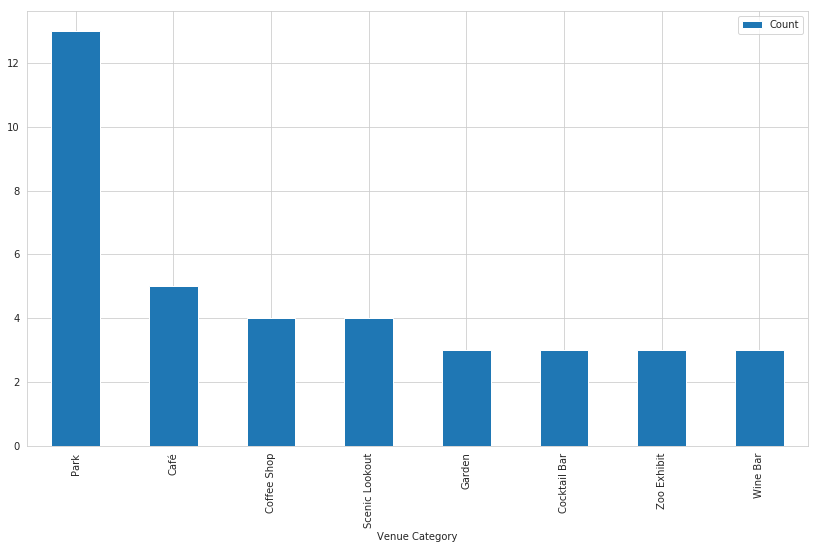

In [28]:
top_most_popular_tourists_attractions_categories.plot.bar(x='Venue Category', figsize=(14,8))

Following map presents all top 100 attraction in Prague. In black presented are tourist attractions, and in green non-tourists attractions.

In further analysis only tourists attractions are used.

![Map of top attractions](img/2019-01-07-23-09-36.png)

In [29]:
map_top_attractions = folium.Map(location=[50.08804,14.42076], zoom_start=13)

for _, venue in most_popular_tourists_attractions.iterrows():
    folium.CircleMarker(
        [venue['Venue Latitude'], venue['Venue Longitude']],
        radius=4,
        color='black',
        popup=folium.Popup(venue['Venue Name'])
    ).add_to(map_top_attractions)
    
for _, venue in most_popular_non_tourists_attractions.iterrows():
    folium.CircleMarker(
        [venue['Venue Latitude'], venue['Venue Longitude']],
        radius=4,
        color='green',
        popup=folium.Popup(venue['Venue Name'])
    ).add_to(map_top_attractions)
    
map_top_attractions

### Prague's top hotels

Following map presents location of top 25 hotels in Prague, Czech Republic amongst the Foursquare users.

It is clearly visible that about half of the top hotels are located in the Old Town, but surprisingly other half is located all around the ctiy, and the 1/3 on the outskirts.

Hotels in the outskirts might suggest the existance of some kind of business centres located there, however that is out-of-scope of this report.

![Map of top hotels](img/2019-01-07-23-40-52.png)

In [30]:
map_most_popular_hotels = folium.Map(location=[50.08804,14.42076], zoom_start=13)

for _, hotel in most_popular_hotels.iterrows():
    folium.CircleMarker(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=5,
        color='blue',
        popup=folium.Popup(hotel['Hotel Name'])
    ).add_to(map_most_popular_hotels)
    
map_most_popular_hotels

### Attractions around top hotels

Following map presents locaions of top 25 Prague's hotels and the top attractions around them. In red marked are the tourists attractions, and in yellow non-tourists places.

There are quite a few non-tourists places, but there are mainly places worth to be visited by tourists.

Many hotels, especially in the Old Town, share the attractions because of close distance to each other.

At this stage initial findings suggest that the best place to stay will be the Old Town (which is not that surprising).


![Map of attractions around top hotels](img/2019-01-08-00-04-29.png)

In [31]:
most_popular_tourists_attracations_around_most_popular_hotels = most_popular_attracations_around_most_popular_hotels[
    ~most_popular_attracations_around_most_popular_hotels['Venue Category'].isin(not_tourists_attractions_categories)
]

most_popular_non_tourists_attracations_around_most_popular_hotels = most_popular_attracations_around_most_popular_hotels[
    most_popular_attracations_around_most_popular_hotels['Venue Category'].isin(not_tourists_attractions_categories)
]

In [32]:
map_attractions_around_top_hotels = folium.Map(location=[50.08804,14.42076], zoom_start=13)

for _, hotel in most_popular_hotels.iterrows():
    folium.CircleMarker(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=5,
        color='blue',
        popup=folium.Popup(hotel['Hotel Name'])
    ).add_to(map_attractions_around_top_hotels)
    
    folium.Circle(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=1000,
        color='blue',
        opacity=0.25,
        fill=True,
        fill_opacity=0.25
    ).add_to(map_attractions_around_top_hotels)
    
    tourists_attracations = most_popular_tourists_attracations_around_most_popular_hotels[
        most_popular_tourists_attracations_around_most_popular_hotels['Hotel Id'] == hotel['Hotel Id']
    ]
    
    non_tourists_attracations = most_popular_non_tourists_attracations_around_most_popular_hotels[
        most_popular_non_tourists_attracations_around_most_popular_hotels['Hotel Id'] == hotel['Hotel Id']
    ]
    
    for _, venue in tourists_attracations.iterrows():
        folium.CircleMarker(
            [venue['Venue Latitude'], venue['Venue Longitude']],
            radius=1,
            color='red',
            popup=folium.Popup(venue['Venue Name'])
        ).add_to(map_attractions_around_top_hotels) 
        
    for _, venue in non_tourists_attracations.iterrows():
        folium.CircleMarker(
            [venue['Venue Latitude'], venue['Venue Longitude']],
            radius=1,
            color='yellow',
            popup=folium.Popup(venue['Venue Name'])
        ).add_to(map_attractions_around_top_hotels) 
    
map_attractions_around_top_hotels

### Top attractions around top hotels

Inspecting and visualising the top attractions out of attractions near hotels brings first surprise! Only a few of attractions around hotels are in top 100 Prague's attractions. This is visible on the following map.

![Map of top attractions around top hotels](img/2019-01-08-00-09-56.png)

In [33]:
top_attractions_around_top_hotels = most_popular_tourists_attracations_around_most_popular_hotels[
    most_popular_tourists_attracations_around_most_popular_hotels['Venue Id'].isin(most_popular_tourists_attractions['Venue Id'])
]

In [34]:
map_top_attractions_around_top_hotels = folium.Map(location=[50.08804,14.42076], zoom_start=13)

for _, hotel in most_popular_hotels.iterrows():
    folium.CircleMarker(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=5,
        color='blue',
        popup=folium.Popup(hotel['Hotel Name'])
    ).add_to(map_top_attractions_around_top_hotels)
    
    folium.Circle(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=1000,
        color='blue',
        opacity=0.25,
        fill=True,
        fill_opacity=0.25
    ).add_to(map_top_attractions_around_top_hotels)
    
    for _, venue in top_attractions_around_top_hotels[top_attractions_around_top_hotels['Hotel Id'] == hotel['Hotel Id']].iterrows():
        folium.CircleMarker(
            [venue['Venue Latitude'], venue['Venue Longitude']],
            radius=4,
            color='black',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            popup=folium.Popup(venue['Venue Name'])
        ).add_to(map_top_attractions_around_top_hotels)
        
map_top_attractions_around_top_hotels

In [35]:
number_of_top_attractions_per_top_hotel = top_attractions_around_top_hotels \
    .groupby(['Hotel Name', 'Hotel Id']) \
    .count()['Venue Id'] \
    .reset_index(name='Count') \
    .sort_values(['Count'], ascending=False)

In [36]:
print('Hotels have between', number_of_top_attractions_per_top_hotel.min()['Count'], 'and', number_of_top_attractions_per_top_hotel.max()['Count'], 'top attractions')

Hotels have between 1 and 6 top attractions


Let's remove the hotels with less than 4 top attractions. The result presents as follows

In [37]:
top_x_hotels_per_number_of_top_attractions = number_of_top_attractions_per_top_hotel[number_of_top_attractions_per_top_hotel['Count'] > 3]
top_x_hotels_per_number_of_top_attractions[['Hotel Name', 'Count']]

,Hotel Name,Count
3,Grand Majestic Plaza,6
0,Czech Inn,5
2,Four Seasons Hotel Prague (Hotel Four Seasons ...,5
15,ibis Praha Old Town,5
4,Hilton Prague,4
6,Hotel Grandium Prague,4
8,InterContinental Prague,4
9,Mama Shelter,4
13,President Hotel,4


In [38]:
print('There are only', top_x_hotels_per_number_of_top_attractions.shape[0], 'those hotels.')

There are only 9 those hotels.


Those top hotels and attractions around them are presented on the following map.

![Map of top attractions around top X hotels](img/2019-01-08-21-21-40.png)

In [ ]:
map_top_attractions_around_top_x_hotels = folium.Map(location=[50.08804,14.42076], zoom_start=13)

foo = most_popular_hotels[most_popular_hotels['Hotel Id'].isin(top_x_hotels_per_number_of_top_attractions['Hotel Id'].unique())]

for _, hotel in foo.iterrows():
    folium.CircleMarker(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=5,
        color='blue',
        popup=folium.Popup(hotel['Hotel Name'])
    ).add_to(map_top_attractions_around_top_x_hotels)
    
    folium.Circle(
        [hotel['Hotel Latitude'], hotel['Hotel Longitude']],
        radius=1000,
        color='blue',
        opacity=0.25,
        fill=True,
        fill_opacity=0.25
    ).add_to(map_top_attractions_around_top_x_hotels)
    
    for _, venue in top_attractions_around_top_hotels[top_attractions_around_top_hotels['Hotel Id'] == hotel['Hotel Id']].iterrows():
        folium.CircleMarker(
            [venue['Venue Latitude'], venue['Venue Longitude']],
            radius=4,
            color='black',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            popup=folium.Popup(venue['Venue Name'])
        ).add_to(map_top_attractions_around_top_x_hotels)

map_top_attractions_around_top_x_hotels

### Clustering top tourists attractions

To get some more context and data for comparison, let's cluster the top Prague's attraction in order to identify the best tourists areas.

The DBSCAN method from sci-kit learn library is one of the methods of such analysis.

The results of clustering shows the following map.

It is clearly visible that the most of attractions is located in the cluster consisting of Old Town, Hradcany and Holesovice. All of those locations are the popular tourists places.

![Clustered top attractions](img/2019-01-08-22-43-35.png)

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
most_popular_tourists_attractions_gpses = most_popular_tourists_attractions[['Venue Latitude', 'Venue Longitude']].values

In [45]:
kms_per_radian = 6371.0088
kms_between_attractions = 0.5
epsilon = kms_between_attractions / kms_per_radian
dbscan = DBSCAN(eps=epsilon, min_samples=3, algorithm='ball_tree', metric='haversine')
clusters = dbscan.fit_predict(np.radians(most_popular_tourists_attractions_gpses))

In [43]:
clustered_most_populat_tourists_attractions = most_popular_tourists_attractions.copy()
clustered_most_populat_tourists_attractions['Cluster'] = clusters

In [ ]:
map_clustered_most_populat_tourists_attractions = folium.Map(location=[50.08804,14.42076], zoom_start=13)
rainbow = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']

for _, venue in clustered_most_populat_tourists_attractions.iterrows():
    folium.CircleMarker(
        [venue['Venue Latitude'], venue['Venue Longitude']],
        radius=(1 if venue['Cluster'] == -1 else 2),
        color='black' if venue['Cluster'] == -1 else rainbow[venue['Cluster']],
        popup=folium.Popup(venue['Venue Name'])
    ).add_to(map_clustered_most_populat_tourists_attractions)
    
    if venue['Cluster'] > -1:
        folium.Circle(
            [venue['Venue Latitude'], venue['Venue Longitude']],
            radius=kms_between_attractions*1000,
            stroke=False,
            fill=True,
            fill_color=rainbow[venue['Cluster']],
            fill_opacity=0.25
        ).add_to(map_clustered_most_populat_tourists_attractions)

map_clustered_most_populat_tourists_attractions

## Discussion

The aim of this report is to assess the feasibility of locating the best possible hotel within range of as many local attractions as possible. The attractions which, as defined during data analysis, are the most popuplar tourists venues. For the sake of the exercise hotels and attractions of Prague in Czech Republic are used.

The report analises and shows on the map the top 25 hotels and top attractions around them. The most surpising finding is that the top attractions around the hotel match the global Prague top attraction only in a small fraction.

Because of that fact one cannot ultimately select the best hotel based on the approach but defintelly take it as sugestion.

To support this claim, the report shows also clustered Prague's top attractions. And when it is not shown on a single map, one can easily check that the biggeset attraction clusters corresponds to the radius of the top selected hotels.

## Conclussion

The results of the the investigated approach are far from the ideal. There is defintelly a lot of space for improvement in all stages of analysis: starting from the data collection, through methodology, ending on the clustering method. However, I conclude the overall approach to be correct.

Possible approaches to improve the results are:

- Modify Foursquare API call to return straigh away only venues interesting for tourists.
- Rank hotels by calculating how many Prague's' top attractions are around them.
- Investigate different clustering methods.